In [1]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "12_generation/12e_image_captioning.ipynb"
_nb_title = "이미지 캡션"
_nb_message = """
이 노트북은 ML 모델을 훈련해 이미지에 대한 캡션을 생성하는 방법을 보인다. 훈련 데이터셋은 COCO 대규모 객체 감지, 세분화, 캡션 데이터셋이다.
"""
### no need to change any of this
_icons=["https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/ychoi-kr/practical-ml-vision-book-ko/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>AI Platform Notebook에서 실행</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Google Colab에서 실행</a></td><td><a target="_blank" href="{2}"><img src="{6}" />GitHub에서 소스 보기</a></td><td><a href="{3}"><img src="{7}" />노트북 내려받기</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=%EC%9D%B4%EB%AF%B8%EC%A7%80+%EC%BA%A1%EC%85%98&download_url=https%3A%2F%2Fgithub.com%2Fychoi-kr%2Fpractical-ml-vision-book-ko%2Fraw%2Fmaster%2F12_generation%2F12e_image_captioning.ipynb"><img src="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png"/>AI Platform Notebook에서 실행</a></td><td><a target="_blank" href="https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/12_generation/12e_image_captioning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Google Colab에서 실행</a></td><td><a target="_blank" href="https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/12_generation/12e_image_captioning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />GitHub에서 소스 보기</a></td><td><a href="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/12_generation/12e_image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />노트북 내려받기</a></td></table><br/><br/><h1>이미지 캡션</h1>
이 노트북은 ML 모델을 훈련해 이미지에 대한 캡션을 생성하는 방법을 보인다. 훈련 데이터셋은 COCO 대규모 객체 감지, 세분화, 캡션 데이터셋이다.


## GPU 활성화
이 저장소의 노트북들은 GPU를 사용하면 더 빨리 실행된다. 

코랩에서:
* 수정 → 노트 설정 메뉴로 이동
* 하드웨어 가속기 드롭다운에서 GPU를 선택

Cloud AI Platform Notebooks에서:
* https://console.cloud.google.com/ai-platform/notebooks 로 이동
* GPU를 포함한 인스턴스를 생성하거나, 인스턴스를 선택하고 GPU를 추가

다음으로, 텐서플로로 GPU에 연결할 수 있는지 확인.

In [ ]:
# 코랩에서는 불필요
%pip install --user --quiet tfds-nightly # In Nov 2020, coco_captions is available only in the nightly build
# %pip uninstall -y h5py
%pip install --user --quiet 'h5py < 3.0.0' # https://github.com/tensorflow/tensorflow/issues/44467

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.9.2
Found GPU at: /device:GPU:0


In [ ]:
!rm -rf /tmp/*tfds*

## 데이터셋을 읽고 시각화

텐서플로 데이터셋 기능을 이용해 [COCO captions](https://www.tensorflow.org/datasets/catalog/coco_captions) 데이터셋을 읽는다.
이 버전은 COCO 2014의 이미지, 경계 박스, 라벨, 캡션을 포함하며, Karpathy 및 Li(2015)에서 정의한 하위 집합으로 분할되고 원본 데이터셋의 일부 데이터 품질 문제(예: 원본 데이터셋에는 캡션이 없음)를 처리한다.

**참고**: 이 데이터 세트는 임시 위치에 저장하기에는 너무 크므로, 데이터를 이 책의 GCS 버킷에 두었다.
미국 이외 지역의 노트북에서 액세스하면 (a) 느리고 (b) 네트워크 요금이 부과될 수 있다.

In [3]:
# 값을 바꿔서 정확도/속도를 제어할 수 있음.
VOCAB_SIZE = 1000 # 수렴 속도를 높이기 위해 더 적은 수의 단어 사용
ATTN_UNITS = 32 # Attention에서 조밀한 층의 크기. 숫자가 클수록 더 세밀함.
EPOCHS = 20 # 정확도를 높이려면 더 오래 훈련
BATCH_SIZE = 64 # 더 큰 배치 크기는 더 부드러운 수렴으로 이어지지만 더 많은 메모리가 필요.
EARLY_STOP_THRESH = 0.0001 # 손실 개선이 이 값보다 작으면 중지
EMBED_DIM = 16 # 이미지와 단어 모두에 대한 임베딩 차원

# 이것은 Inception이 훈련된 것이므로, 사전 훈련된 다른 모델을 사용하지 않는 한
# 변경하지 마라. Inception은 (299, 299, 3)을 입력으로 받고 (64, 2048)을 출력으로
# 제공한다.
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = 2048
ATTN_FEATURES_SHAPE = 64

In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

GCS_DIR="gs://practical-ml-vision-book/"

def filter_for_crowds(example):
    return (tf.math.count_nonzero(example['objects']['is_crowd']) > 0)

def get_image_label(example):
  captions = example['captions']['text'] # all the captions
  img_id = example['image/id']
  img = example['image']
  img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH)) # inception size
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return {
        'image_tensor': img,
        'image_id': img_id,
        'captions': captions
  }

trainds = tfds.load('coco_captions',
                    split='train',
                    shuffle_files=False,
                    data_dir=GCS_DIR)

# 다음 방법 중 하나로 이미지 수를 줄인다.
trainds = trainds.filter(filter_for_crowds)
#trainds = trainds.take(10000)

trainds = trainds.map(get_image_label)

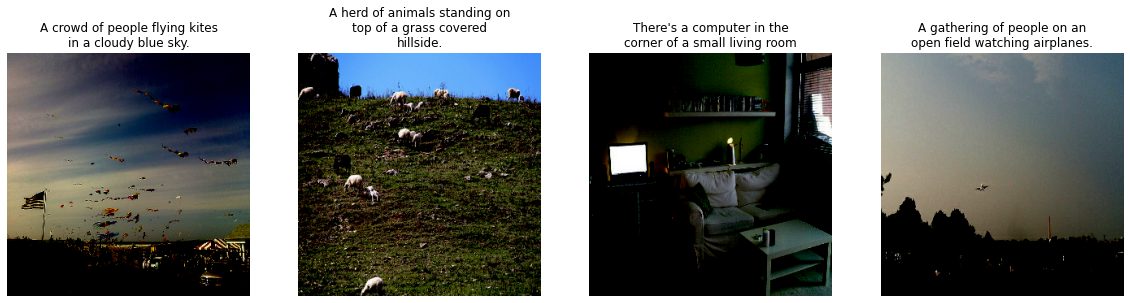

In [5]:
from textwrap import wrap

f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
  ax[idx].imshow(data['image_tensor'].numpy())
  #ax[idx].set_xlabel('image_id={}'.format(data['image_id'].numpy()))
  caption = '\n'.join(wrap(data['captions'].numpy()[0].decode('utf-8'), 30))
  ax[idx].set_title(caption)
  ax[idx].axis('off')

## 캡션을 토큰화

각 캡션에 시작 토큰과 끝 토큰을 추가한다.

그런 다음 캡션을 소문자로 만들고 구두점 등을 제거하는 Keras 토크나이저로 보낸다. 또한 가장 자주 사용되는 단어만 유지한다.

In [6]:
# 토크나이저에 먹일 캡션을 모두 가져오기
STOPWORDS = {'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than'}
MAX_CAPTION_LEN = 1
def preprocess_caption(c):
    global MAX_CAPTION_LEN
    caption = "starttoken {} endtoken".format(c.decode('utf-8'))
    words = [word for word in caption.lower().split()
            if word not in STOPWORDS]
    MAX_CAPTION_LEN = max(MAX_CAPTION_LEN, len(words))
    return (' '.join(words))


train_captions = []
for data in trainds:
  str_captions = [preprocess_caption(c) for c in data['captions'].numpy()]
  train_captions.extend(str_captions)
print(train_captions[:5])

['starttoken crowd people flying kites cloudy blue sky. endtoken', 'starttoken large number kites flying sky endtoken', 'starttoken sky full kites flown crowd. endtoken', 'starttoken large group people flying series kites. endtoken', 'starttoken people field kites flying air. endtoken']


In [7]:
# 어휘에서 가장 자주 나오는 단어를 선택하고 구두점 등을 제거.
tokenizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, output_sequence_length=MAX_CAPTION_LEN)
tokenizer.adapt(train_captions)

In [8]:
tokenizer(train_captions[:5])

<tf.Tensor: shape=(5, 33), dtype=int64, numpy=
array([[  2,  18,   4,  21,  22, 350,  72,  89,   3,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  2,  10, 139,  22,  21,  89,   3,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  2,  89,  58,  22, 366,  18,   3,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  2,  10,   5,   4,  21, 782,  22,   3,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  2,   4,  13,  22,  21,  65,   3,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]])>

In [9]:
tokenizer(['starttoken'])

<tf.Tensor: shape=(1, 33), dtype=int64, numpy=
array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>

In [10]:
tokenizer([train_captions[0]])[0]

<tf.Tensor: shape=(33,), dtype=int64, numpy=
array([  2,  18,   4,  21,  22, 350,  72,  89,   3,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])>

In [11]:
for wordid in tokenizer([train_captions[0]])[0]:
    print(tokenizer.get_vocabulary()[wordid], end=' ')

starttoken crowd people flying kites cloudy blue sky endtoken                         

In [12]:
def create_batched_ds(trainds, batchsize):
  # 캡션 문자열에 토큰화, 패딩을 수행하고 이미지, 캡션을 생성하는 생성기
  def generate_image_captions():
    for data in trainds:
      captions = data['captions']
      img_tensor = data['image_tensor']
      str_captions = [preprocess_caption(c) for c in data['captions'].numpy()]
      padded = tokenizer(str_captions)
      for caption in padded:
        yield img_tensor, caption # repeat image
  
  return tf.data.Dataset.from_generator(
      generate_image_captions,
      (tf.float32, tf.int32)).batch(batchsize)

for img, caption in create_batched_ds(trainds, 193).take(2):
    print(img.shape, caption.shape)
    print(caption[0])

(193, 299, 299, 3) (193, 33)
tf.Tensor(
[  2  18   4  21  22 350  72  89   3   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(33,), dtype=int32)
(193, 299, 299, 3) (193, 33)
tf.Tensor(
[  2  54 161   7  54   1   3   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(33,), dtype=int32)


## 캡셔닝 모델 만들기

이미지 인코더와 캡션 디코더로 구성된다.
캡션 디코더는 입력 이미지의 다른 부분에 초점을 맞추는 어텐션 메커니즘을 통합한다.

In [13]:
class ImageEncoder(tf.keras.Model):
   def __init__(self, embedding_dim):
     super(ImageEncoder, self).__init__()
     inception = tf.keras.applications.InceptionV3(
         include_top=False,
         weights='imagenet'
     )
     self.model = tf.keras.Model(inception.input,
                                 inception.layers[-1].output)
     self.fc = tf.keras.layers.Dense(embedding_dim)

   def call(self, x):
     x = self.model(x)
     x = tf.reshape(x, (x.shape[0], -1, x.shape[3]))
     x = self.fc(x)
     x = tf.nn.relu(x)
     return x

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder 출력) shape == (batch_size, 64, embedding_dim)
    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # 이렇게 하면 각 이미지 기능에 대해 정규화되지 않은 점수가 제공된다.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CaptionDecoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(CaptionDecoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=MAX_CAPTION_LEN)
    
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # 어텐션을 별도 모델로 정의
    context_vector, attention_weights = self.attention(features, hidden)

    # 임베딩 통과 후 x의 모양 == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # 연결 후 x의 모양 == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 이어 붙인 벡터를 GRU에 전달
    output, state = self.gru(x)

    # 모양 == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x 모양 == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # 출력 모양 == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

encoder = ImageEncoder(EMBED_DIM)
decoder = CaptionDecoder(EMBED_DIM, ATTN_UNITS, VOCAB_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

87910968/87910968 [==============================] - 1s 0us/step


## 훈련 루프

여기서는 한 번에 한 단어씩 디코더 입력(dec_input)에 추가해야 하므로 커스텀 훈련 루프를 사용한다.

In [14]:
loss_plot = []
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # 캡션이 이미지와 무관하므로 각 배치에 대한 숨겨진 상태를 초기화
  hidden = decoder.reset_state(batch_size=target.shape[0])

  # [[3],[3], ...], 즉 시작 토큰으로 예측 배치를 초기화
  dec_input = tf.expand_dims([tokenizer(['starttoken'])[0][0]] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # 디코더를 통해 기능 전달
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # 교사 강제 사용
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [15]:
import time

batched_ds = create_batched_ds(trainds, BATCH_SIZE)

prev_loss = 999
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    num_steps = 0

    for batch, (img_tensor, target) in enumerate(batched_ds):
      batch_loss, t_loss = train_step(img_tensor, target)
      total_loss += t_loss
      num_steps += 1

      if batch % 100 == 0:
        print ('Epoch {} Batch {} Loss {:.4f}'.format(
            epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    
    current_loss = total_loss / num_steps
    
    # 나중에 플롯할 에포크 종료 손실 값 저장
    loss_plot.append(current_loss)

    ckpt_manager.save()

    print ('Epoch {} Loss {:.6f} Time taken {:.1f} sec'.format(
        epoch + 1,
        current_loss,
        time.time() - start))
    
    # 수렴되면 중지
    improvement = prev_loss - current_loss
    if improvement < EARLY_STOP_THRESH:
        print("Stopping because improvement={} < {}".format(improvement, EARLY_STOP_THRESH))
        break
    prev_loss = current_loss

Epoch 1 Batch 0 Loss 1.4843
Epoch 1 Batch 100 Loss 1.0934
Epoch 1 Batch 200 Loss 1.1360
Epoch 1 Batch 300 Loss 1.1053
Epoch 1 Batch 400 Loss 1.2169
Epoch 1 Loss 1.128266 Time taken 716.8 sec
Epoch 2 Batch 0 Loss 1.1708
Epoch 2 Batch 100 Loss 1.0933
Epoch 2 Batch 200 Loss 1.1344
Epoch 2 Batch 300 Loss 1.1044
Epoch 2 Batch 400 Loss 1.2158
Epoch 2 Loss 1.109267 Time taken 545.1 sec
Epoch 3 Batch 0 Loss 1.1700
Epoch 3 Batch 100 Loss 1.0932
Epoch 3 Batch 200 Loss 1.1338
Epoch 3 Batch 300 Loss 1.1041
Epoch 3 Batch 400 Loss 1.2150
Epoch 3 Loss 1.108812 Time taken 545.5 sec
Epoch 4 Batch 0 Loss 1.1698
Epoch 4 Batch 100 Loss 1.0938
Epoch 4 Batch 200 Loss 1.1333
Epoch 4 Batch 300 Loss 1.1036
Epoch 4 Batch 400 Loss 1.2146
Epoch 4 Loss 1.108449 Time taken 563.7 sec
Epoch 5 Batch 0 Loss 1.1694
Epoch 5 Batch 100 Loss 1.0932
Epoch 5 Batch 200 Loss 1.1327
Epoch 5 Batch 300 Loss 1.1034
Epoch 5 Batch 400 Loss 1.2142
Epoch 5 Loss 1.108228 Time taken 549.6 sec
Epoch 6 Batch 0 Loss 1.1689
Epoch 6 Batch 100

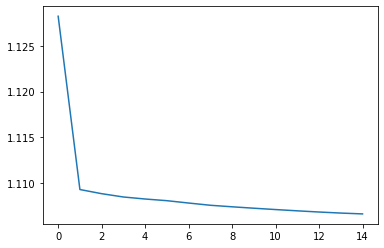

In [16]:
plt.plot(loss_plot);

## 예측

예측하기 위해 한 번에 한 단어씩 캡션을 생성하여 디코더에 이전 예측을 제공한다.

In [17]:
for id in range(10):
    print(id, tokenizer.get_vocabulary()[id])

0 
1 [UNK]
2 starttoken
3 endtoken
4 people
5 group
6 man
7 standing
8 baseball
9 street


In [18]:
## 훈련된 모델을 사용한 확률적 예측
def plot_attention(image, result, attention_plot):
  fig = plt.figure(figsize=(10, 10))

  len_result = len(result)
  num_panels = len_result//2
  if num_panels*2 < len_result:
    num_panels += 1
  for l in range(len_result):
    temp_att = np.resize(attention_plot[l], (8, 8))
    ax = fig.add_subplot(len_result//2, num_panels, l+1)
    ax.set_title(result[l])
    img = ax.imshow(image)
    ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
    ax.axis('off')

  plt.tight_layout()
  plt.show()

def predict_caption(filename):
  attention_plot = np.zeros((MAX_CAPTION_LEN, ATTN_FEATURES_SHAPE))
  hidden = decoder.reset_state(batch_size=1)
  img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
  img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH)) # inception size
  img_tensor_val = tf.keras.applications.inception_v3.preprocess_input(img)

  features = encoder(tf.expand_dims(img_tensor_val, axis=0))
  dec_input = tf.expand_dims([tokenizer(['starttoken'])[0][0]], 1)
  result = []
  previous_word_ids = []
  for i in range(MAX_CAPTION_LEN):
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
    attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

    if i < 10:
        # <end>를 원하지 않으므로 <pad> <unk> <start> <end>를 마스크 아웃
        masked_predictions = predictions[0]
        mask = [0.0, 0, 0, 0] + [1.0] * (masked_predictions.shape[0] - 4)
        # end는 다섯 번째 단어 이후에 OK
        if i > 5:
            mask[3] = 1
        # 반복되는 단어를 배제
        for p in previous_word_ids:
          mask[p] = 0
        mask = tf.convert_to_tensor(mask)
        masked_predictions *= mask
        # 상위 3개 단어만 유지하고 로그 분포에서 제외
        top_probs, top_idxs = tf.math.top_k(input=masked_predictions, k=3, sorted=False)
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]
    else:
        # 예측에 의해 주어진 로그 분포에서 가져옴
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
    result.append(tokenizer.get_vocabulary()[predicted_id])
    previous_word_ids.append(predicted_id)
    
    if tokenizer.get_vocabulary()[predicted_id] == 'endtoken':
      return img, result, attention_plot

    dec_input = tf.expand_dims([predicted_id], 0)
  
  attention_plot = attention_plot[:len(result), :]
  return img, result, attention_plot

man people standing group baseball large
group man people standing street baseball
man people standing street group baseball
man people standing group street large
group people man baseball street large standing


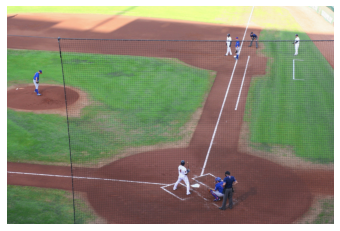

In [19]:
filename="gs://practical-ml-vision-book/images/redhawks_game.jpg"
for i in range(5):
    image, caption, attention_plot = predict_caption(filename)
    print(' '.join(caption[:-1]))
img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img);
plt.axis('off');

이 모델은 이미지의 주요 측면인 사람, 필드, 야구를 포착했지만, 중앙의 흰색 선 때문에 헷갈려서 경기가 길거리에서 열리고 있을 것으로 생각한다.

## 책에 넣을 도표

In [ ]:
print(encoder.summary())

Model: "image_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, None, None, 2048)  21802784  
_________________________________________________________________
dense (Dense)                multiple                  524544    
Total params: 22,327,328
Trainable params: 22,292,896
Non-trainable params: 34,432
_________________________________________________________________
None


In [ ]:
print(decoder.summary())

Model: "caption_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1280000   
_________________________________________________________________
gru (GRU)                    multiple                  1575936   
_________________________________________________________________
dense_1 (Dense)              multiple                  262656    
_________________________________________________________________
dense_2 (Dense)              multiple                  2565000   
_________________________________________________________________
bahdanau_attention (Bahdanau multiple                  394753    
Total params: 6,078,345
Trainable params: 6,078,345
Non-trainable params: 0
_________________________________________________________________
None


Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.